In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import time
import math
import random
import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import datasets, layers, models
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from sklearn.cluster import KMeans, AgglomerativeClustering
#from tensorflow.keras.datasets import cifar10 
from keras.datasets import fashion_mnist 
#from sklearn.metrics import silhouette_samples, silhouette_score

mod = sys.modules[__name__]

In [2]:
def distribution_check(dataset):
        #분포가 다름;
    one,two,three,four,five,six,seven,eight,nine,ten=0,0,0,0,0,0,0,0,0,0

    for i in range(len(dataset)):
        if(dataset[i]==1):    one+=1
        elif(dataset[i]==2):  two+=1
        elif(dataset[i]==3):  three+=1
        elif(dataset[i]==4):  four+=1
        elif(dataset[i]==5):  five+=1
        elif(dataset[i]==6):  six+=1
        elif(dataset[i]==7):  seven+=1
        elif(dataset[i]==8):  eight+=1
        elif(dataset[i]==9):  nine+=1
        elif(dataset[i]==0):  ten+=1

    #print(one,two,three,four,five,six,seven,eight,nine,ten)
    #print("Sum : ", one+two+three+four+five+six+seven+eight+nine+ten)
    sums = one+two+three+four+five+six+seven+eight+nine+ten
    for_graph=[one,two,three,four,five,six,seven,eight,nine,ten]
    
    return for_graph, sums

def local_model_generate(model): #초기 모델 생성
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

def step_function(data):
    if data > 0:
        return 1
    else:
        return 0

def sigmoid(data):
    return 1/(1+np.exp(-data))

def relu(data):
    return np.maximum(0,data)

def random_check(local, train_data, test_data):
    check_distribution_train_data, check_distribution_test_data, y_train_tmp, y_test_tmp = [], [], [], []
    sum1, sum2, data_index = 0,0, np.arange(0,10)

    for j in range(len(train_data)):
        y_train_tmp.append(np.argmax(train_data[j])) #원핫인코딩에서 다시 0~9 레이블로 변환

    for j in range(len(test_data)):
        y_test_tmp.append(np.argmax(test_data[j]))

    check_distribution_train_data, sum_train = distribution_check(y_train_tmp) #한번 밖에 실행 못함
    check_distribution_test_data, sum_test = distribution_check(y_test_tmp)
    sum1, sum2 = (sum1 + sum_train), (sum2 + sum_test)
    
    return check_distribution_train_data, check_distribution_test_data


In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape, x_test.shape)
num_train, num_test = len(x_train),  len(x_test) 

(60000, 28, 28) (10000, 28, 28)


In [4]:
local = 21 # 10개 : 1~10 => 11은 포함 안됨
batch_size, epochs = 32, 5
global_epoch = 0
num_layers = 8

In [5]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print("Step 1 x_train shape:", x_train.shape)

x_train = x_train.reshape((num_train, 28, 28, 1))
x_test = x_test.reshape((num_test, 28, 28, 1))

print("Step 2 x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
# convert class vectors to binary class matrices => one hot encoding 지금은 [3,6,2,5,4,8..] 섞여있음 

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Step 1 x_train shape: (60000, 28, 28)
Step 2 x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [6]:
global_epoch = 0

print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
    globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [],[]  
    globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [],[]  


for n in range(1,local): #x_train_range, 잘 작동함 => 확인 완료

    x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
    x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

    tmp, tmp2 = [], []

    num_pick = random.randint(1000, 5000) #변동 사항 #int(len(list(x_train_range))/local)
    num_pick2 = int(len(x_test_range)/local) #test 데이터는 원래대로 항상 일정한 비율로 주면 될듯 => 어느정도 분량 이상 있어야 함
    
    tmp = random.sample(list(x_train_range), num_pick)  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
    tmp2 = random.sample(list(x_test_range), num_pick2)

    for i in range(len(tmp)):
        globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
        globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
        #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소갯수들 추출했으니 안에서 삭제  => 오래걸림

    for j in range(len(tmp2)):
        globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
        globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
        #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 1000개 추출했으니 안에서 삭제  => 오래걸림
    
    print("CHECK :", n," 번째 로컬 클라이언트 Number of Training sets : ", len(globals()['L{}_x_train'.format(n)]), "   Number of Training sets : ", len(globals()['L{}_x_test'.format(n)]))

print("check=>: should be 0 == ", len(x_train_range))  #원소 하나도 없어야 함. 확인.
print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!")

0  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  3928    Number of Training sets :  476
CHECK : 2  번째 로컬 클라이언트 Number of Training sets :  1005    Number of Training sets :  476
CHECK : 3  번째 로컬 클라이언트 Number of Training sets :  3433    Number of Training sets :  476
CHECK : 4  번째 로컬 클라이언트 Number of Training sets :  2786    Number of Training sets :  476
CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  3630    Number of Training sets :  476
CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  2150    Number of Training sets :  476
CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  1781    Number of Training sets :  476
CHECK : 8  번째 로컬 클라이언트 Number of Training sets :  1585    Number of Training sets :  476
CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  4539    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  2463    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  3037    Number of Trainin

In [7]:
#준비된 데이터 (IID / NON-IID) np.array로

local = 21

global_epoch = 0
FedAvg_ACC, FedAvg_LOSS, fedavg_acc, fedavg_loss, acc, loss = [], [], [], [], 0, 0
num_layers_list = [0,2,4,6,7]
label_list = []

VAR_final_list_w, VAR_final_list_b = [], []


for i in range(1,local):
    globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
    globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
    globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
    globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


print("\n\n",global_epoch, "번째 global epoch에서 로컬 클라이언트 학습시작!\n\n학습 중 ...\n")
now = time.time()

for i in range(1,local):
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = models.Sequential()  ##!!!!!!! 이게 글로벌 epoch에서는 2번째 부터 들어가면 안됨
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = local_model_generate(globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)])      # initialize 필요 => 모델 프레임 구축

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)

    loss, acc = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].evaluate(globals()['L{}_x_test'.format(i,global_epoch)], globals()['L{}_y_test'.format(i)], verbose=2)
    
    fedavg_acc.append(acc)  #acc 넣기
    fedavg_loss.append(loss)  #loss 넣기


print(global_epoch, "번째 global epoch 로컬 클라이언트 학습완료!,  Total Training time : ", time.time()-now,"\n\n")

# 로컬 모델들 학습 완료하였고 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------

for i in range(1, local):
    for layer_index in num_layers_list:
        w = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].layers[layer_index].get_weights() #get_weights = w[0],b[1]로 구성

        globals()['L{}_layer{}_w_tmp'.format(i,layer_index)] = w      # 클러스터링 용도
        globals()['L{}_layer{}_w'.format(i,layer_index)] = w          # weight aggregation 용도
            

for layer_index in num_layers_list:

    globals()['layer{}_W_tmp'.format(layer_index)] = []
    globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = 0  #FedAvg 용도
    
    globals()['var_list_layer{}_w'.format(layer_index)] = []
    globals()['var_list_layer{}_b'.format(layer_index)] = []
  
    w_scaler = 0
    #------------------------------------------------FedAvg--------------------------------------------------------
    for i in range(1, local):
        globals()['var_list_layer{}_w'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][0]))
        globals()['var_list_layer{}_b'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][1]))
      
        w_scaler = len(globals()['L{}_x_train'.format(i)]) / 60000
        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + (np.array(globals()['L{}_layer{}_w'.format(i,layer_index)]) * w_scaler)
    
    globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = np.array(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)]) / (local-1)   #np.array로 변함
    
    VAR_final_list_w.append(globals()['var_list_layer{}_w'.format(layer_index)])
    VAR_final_list_b.append(globals()['var_list_layer{}_b'.format(layer_index)])
    
#---------------------------------------------------------메모리 삭제-------------------------------------------------------------------


FedAvg_ACC.append(fedavg_acc)
FedAvg_LOSS.append(fedavg_loss)

## G{}_num_clusters_in_layer{}_w 에 속하는 거 말고 삭제 = 메모리 낭비




 0 번째 global epoch에서 로컬 클라이언트 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.5055 - accuracy: 0.8004
15/15 - 0s - loss: 0.7189 - accuracy: 0.7353
15/15 - 0s - loss: 0.5132 - accuracy: 0.8088
15/15 - 0s - loss: 0.5829 - accuracy: 0.7773
15/15 - 0s - loss: 0.5598 - accuracy: 0.8067
15/15 - 0s - loss: 0.5981 - accuracy: 0.7815
15/15 - 0s - loss: 0.6271 - accuracy: 0.7605
15/15 - 0s - loss: 0.6594 - accuracy: 0.7605
15/15 - 0s - loss: 0.5214 - accuracy: 0.8298
15/15 - 0s - loss: 0.5864 - accuracy: 0.7668
15/15 - 0s - loss: 0.5577 - accuracy: 0.7920
15/15 - 0s - loss: 0.4626 - accuracy: 0.8235
15/15 - 0s - loss: 0.5436 - accuracy: 0.7920
15/15 - 0s - loss: 0.5403 - accuracy: 0.8046
15/15 - 0s - loss: 0.5078 - accuracy: 0.8046
15/15 - 0s - loss: 0.6848 - accuracy: 0.7332
15/15 - 0s - loss: 0.6654 - accuracy: 0.7416
15/15 - 0s - loss: 0.8652 - accuracy: 0.6702
15/15 - 0s - loss: 0.6491 - accuracy: 0.7857
15/15 - 0s - loss: 0.5468 - accuracy: 0.8067
0 번째 global epoch 로컬 클라이언트 학습완료!,  Total Training t

<ipython-input-7-9423f5a6d053>:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + (np.array(globals()['L{}_layer{}_w'.format(i,layer_index)]) * w_scaler)


In [8]:
G_epoch = 51

for global_epoch in range(1, G_epoch):

    for layer_index in num_layers_list:
        for i in range(1, local):  #FedAvg
            globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch)] = globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch-1)]   #구조만 필요

            globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch)].layers[layer_index].set_weights(globals()['G{}_w_layer{}'.format(global_epoch-1, layer_index)])  #set_weights
        
  
    #----------------------------------------------------------------데이터 새로 준비----------------------------------------------------------------------------------
    print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

    for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
        globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [],[]  
        globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [],[]  


    for n in range(1,local): #x_train_range, 잘 작동함 => 확인 완료

        x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
        x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

        tmp, tmp2 = [], []

        num_pick = random.randint(1000, 5000) #변동 사항 #int(len(list(x_train_range))/local)
        num_pick2 = int(len(x_test_range)/local) #test 데이터는 원래대로 항상 일정한 비율로 주면 될듯 => 어느정도 분량 이상 있어야 함
        
        tmp = random.sample(list(x_train_range), num_pick)  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
        tmp2 = random.sample(list(x_test_range), num_pick2)

        for i in range(len(tmp)):
            globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
            globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
            #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소갯수들 추출했으니 안에서 삭제  => 오래걸림

        for j in range(len(tmp2)):
            globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
            globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
            #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 1000개 추출했으니 안에서 삭제  => 오래걸림
        
        print("CHECK :", n," 번째 로컬 클라이언트 Number of Training sets : ", len(globals()['L{}_x_train'.format(n)]), "   Number of Training sets : ", len(globals()['L{}_x_test'.format(n)]))

    print("check=>: should be 0 == ", len(x_train_range))  #원소 하나도 없어야 함. 확인.
    print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!")

    for i in range(1,local):
        globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
        globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
        globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
        globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


    print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!\n\n")

    print(global_epoch, " 번째 global epoch에서 로컬 클라이언트 들 학습시작!\n\n학습 중 ...\n")
    

    #-------------------------------------------------------------------여기가 핵심, 알고리즘 3개 따로 학습시켜야 함--------------------------------------------------------------------


    #======================================================================== FedAvg ========================================================================

    fedavg_acc, fedavg_loss, now = [],[], time.time()

    for i in range(1,local):
        # 아까 옮겨줘서 모델 그대로 compile, train 시키면 됨      
        globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

        globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)

        loss, acc = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].evaluate(globals()['L{}_x_test'.format(i)], globals()['L{}_y_test'.format(i)], verbose=2)
        
        fedavg_acc.append(acc)  #acc 넣기
        fedavg_loss.append(loss)  #loss 넣기

    print("------------   ", global_epoch, " 번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time : ", time.time()-now,"---------------------------\n\n")


# 로컬 모델들 학습 완료, 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------


    for i in range(1, local):        
        for layer_index in num_layers_list:
            globals()['L{}_layer{}_w_tmp'.format(i,layer_index)] = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].layers[layer_index].get_weights() #get_weights = w[0],b[1]로 구성, FedAvg
            
    #------------------------------------------------FedAvg--------------------------------------------------------바로 Fedavg 시키기
    
    for layer_index in num_layers_list:
        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = 0

        globals()['var_list_layer{}_w'.format(layer_index)] = []
        globals()['var_list_layer{}_b'.format(layer_index)] = []
        w_scaler = len(globals()['L{}_x_train'.format(i)]) / 60000
        
        for i in range(1, local):
            globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + (np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)])*w_scaler)

        for i in range(1, local):
            globals()['var_list_layer{}_w'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][0]))            
            globals()['var_list_layer{}_b'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][1]))
            
          
        VAR_final_list_w.append(globals()['var_list_layer{}_w'.format(layer_index)])
        VAR_final_list_b.append(globals()['var_list_layer{}_b'.format(layer_index)])
    

    FedAvg_ACC.append(fedavg_acc)
    FedAvg_LOSS.append(fedavg_loss)

    print("\n\n====================================================== One Global Epoch =====================================================================\n\n")

1  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  2450    Number of Training sets :  476
CHECK : 2  번째 로컬 클라이언트 Number of Training sets :  2669    Number of Training sets :  476
CHECK : 3  번째 로컬 클라이언트 Number of Training sets :  3452    Number of Training sets :  476
CHECK : 4  번째 로컬 클라이언트 Number of Training sets :  3685    Number of Training sets :  476
CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  1621    Number of Training sets :  476
CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  3611    Number of Training sets :  476
CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  4072    Number of Training sets :  476
CHECK : 8  번째 로컬 클라이언트 Number of Training sets :  2863    Number of Training sets :  476
CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  4054    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  4062    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  2934    Number of Trainin

<ipython-input-8-e58c13c18cea>:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + (np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)])*w_scaler)


CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  3274    Number of Training sets :  476
CHECK : 8  번째 로컬 클라이언트 Number of Training sets :  2804    Number of Training sets :  476
CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  4490    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  4508    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  4512    Number of Training sets :  476
CHECK : 12  번째 로컬 클라이언트 Number of Training sets :  2425    Number of Training sets :  476
CHECK : 13  번째 로컬 클라이언트 Number of Training sets :  2304    Number of Training sets :  476
CHECK : 14  번째 로컬 클라이언트 Number of Training sets :  4415    Number of Training sets :  476
CHECK : 15  번째 로컬 클라이언트 Number of Training sets :  4135    Number of Training sets :  476
CHECK : 16  번째 로컬 클라이언트 Number of Training sets :  4091    Number of Training sets :  476
CHECK : 17  번째 로컬 클라이언트 Number of Training sets :  4611    Number of Training sets :  476
CHECK : 18  번

15/15 - 0s - loss: 0.8879 - accuracy: 0.7059
15/15 - 0s - loss: 0.7123 - accuracy: 0.6912
15/15 - 0s - loss: 0.6414 - accuracy: 0.7710
15/15 - 0s - loss: 0.8792 - accuracy: 0.6933
15/15 - 0s - loss: 0.8747 - accuracy: 0.6933
15/15 - 0s - loss: 0.7794 - accuracy: 0.7080
15/15 - 0s - loss: 0.8005 - accuracy: 0.7038
15/15 - 0s - loss: 0.8331 - accuracy: 0.6996
15/15 - 0s - loss: 0.7640 - accuracy: 0.7227
------------    4  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  117.90403890609741 ---------------------------




====================================================== One Global Epoch =====================================================================


5  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  4339    Number of Training sets :  476
CHECK : 2  번째 로컬 클라이언트 Number of Training sets :  3273    Number of Training sets :  476
CHECK : 3  번째 로컬 클라이언트 Number of Training sets :  2211    Number of Training sets :  476
CHECK : 4  번째

CHECK : 16  번째 로컬 클라이언트 Number of Training sets :  1607    Number of Training sets :  476
CHECK : 17  번째 로컬 클라이언트 Number of Training sets :  4304    Number of Training sets :  476
CHECK : 18  번째 로컬 클라이언트 Number of Training sets :  1947    Number of Training sets :  476
CHECK : 19  번째 로컬 클라이언트 Number of Training sets :  3117    Number of Training sets :  476
CHECK : 20  번째 로컬 클라이언트 Number of Training sets :  3441    Number of Training sets :  476
check=>: should be 0 ==  60000
7  번째 global_epoch 데이터 랜덤 준비완료!!
7  번째 global_epoch 데이터 랜덤 준비완료!!


7  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.6565 - accuracy: 0.7416
15/15 - 0s - loss: 0.6453 - accuracy: 0.7605
15/15 - 0s - loss: 0.6038 - accuracy: 0.7689
15/15 - 0s - loss: 0.7276 - accuracy: 0.7500
15/15 - 0s - loss: 0.7165 - accuracy: 0.7479
15/15 - 0s - loss: 0.6838 - accuracy: 0.7332
15/15 - 0s - loss: 0.6698 - accuracy: 0.7584
15/15 - 0s - loss: 0.7212 - accuracy: 0.7227
15/15 - 0s - loss: 0.5750 - accuracy: 0.78

CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  3521    Number of Training sets :  476
CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  1486    Number of Training sets :  476
CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  3587    Number of Training sets :  476
CHECK : 8  번째 로컬 클라이언트 Number of Training sets :  1433    Number of Training sets :  476
CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  1721    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  1198    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  4483    Number of Training sets :  476
CHECK : 12  번째 로컬 클라이언트 Number of Training sets :  1367    Number of Training sets :  476
CHECK : 13  번째 로컬 클라이언트 Number of Training sets :  4286    Number of Training sets :  476
CHECK : 14  번째 로컬 클라이언트 Number of Training sets :  2298    Number of Training sets :  476
CHECK : 15  번째 로컬 클라이언트 Number of Training sets :  4731    Number of Training sets :  476
CHECK : 16  번째 

15/15 - 0s - loss: 0.5718 - accuracy: 0.7836
15/15 - 0s - loss: 0.6258 - accuracy: 0.7542
15/15 - 0s - loss: 0.7853 - accuracy: 0.7164
15/15 - 0s - loss: 0.7737 - accuracy: 0.7143
15/15 - 0s - loss: 0.7431 - accuracy: 0.7164
15/15 - 0s - loss: 0.6596 - accuracy: 0.7605
15/15 - 0s - loss: 0.6843 - accuracy: 0.7500
15/15 - 0s - loss: 0.5544 - accuracy: 0.7773
15/15 - 0s - loss: 0.6164 - accuracy: 0.7647
15/15 - 0s - loss: 0.6931 - accuracy: 0.7458
15/15 - 0s - loss: 0.5773 - accuracy: 0.7878
15/15 - 0s - loss: 0.5753 - accuracy: 0.7941
15/15 - 0s - loss: 0.6445 - accuracy: 0.7563
------------    12  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  134.52273678779602 ---------------------------




====================================================== One Global Epoch =====================================================================


13  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  3534    Number of Training sets :  476
CHECK : 2

CHECK : 16  번째 로컬 클라이언트 Number of Training sets :  1477    Number of Training sets :  476
CHECK : 17  번째 로컬 클라이언트 Number of Training sets :  4630    Number of Training sets :  476
CHECK : 18  번째 로컬 클라이언트 Number of Training sets :  2551    Number of Training sets :  476
CHECK : 19  번째 로컬 클라이언트 Number of Training sets :  2419    Number of Training sets :  476
CHECK : 20  번째 로컬 클라이언트 Number of Training sets :  4531    Number of Training sets :  476
check=>: should be 0 ==  60000
15  번째 global_epoch 데이터 랜덤 준비완료!!
15  번째 global_epoch 데이터 랜덤 준비완료!!


15  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.5061 - accuracy: 0.8004
15/15 - 0s - loss: 0.6018 - accuracy: 0.8046
15/15 - 0s - loss: 0.5571 - accuracy: 0.8193
15/15 - 0s - loss: 0.4737 - accuracy: 0.8340
15/15 - 0s - loss: 0.5706 - accuracy: 0.7878
15/15 - 0s - loss: 0.5714 - accuracy: 0.7857
15/15 - 0s - loss: 0.6149 - accuracy: 0.7878
15/15 - 0s - loss: 0.6890 - accuracy: 0.7815
15/15 - 0s - loss: 0.5585 - accuracy: 0

CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  2900    Number of Training sets :  476
CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  3288    Number of Training sets :  476
CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  4229    Number of Training sets :  476
CHECK : 8  번째 로컬 클라이언트 Number of Training sets :  4646    Number of Training sets :  476
CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  1677    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  3401    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  1812    Number of Training sets :  476
CHECK : 12  번째 로컬 클라이언트 Number of Training sets :  2653    Number of Training sets :  476
CHECK : 13  번째 로컬 클라이언트 Number of Training sets :  2887    Number of Training sets :  476
CHECK : 14  번째 로컬 클라이언트 Number of Training sets :  1336    Number of Training sets :  476
CHECK : 15  번째 로컬 클라이언트 Number of Training sets :  3767    Number of Training sets :  476
CHECK : 16  번째 

15/15 - 0s - loss: 0.6362 - accuracy: 0.7878
15/15 - 0s - loss: 0.5651 - accuracy: 0.8004
15/15 - 0s - loss: 0.4899 - accuracy: 0.8382
15/15 - 0s - loss: 0.5138 - accuracy: 0.8130
15/15 - 0s - loss: 0.5918 - accuracy: 0.7626
15/15 - 0s - loss: 0.4773 - accuracy: 0.8004
15/15 - 0s - loss: 0.5933 - accuracy: 0.7794
15/15 - 0s - loss: 0.5698 - accuracy: 0.8109
15/15 - 0s - loss: 0.5557 - accuracy: 0.7983
15/15 - 0s - loss: 0.5511 - accuracy: 0.7836
15/15 - 0s - loss: 0.5613 - accuracy: 0.7941
15/15 - 0s - loss: 0.5015 - accuracy: 0.8172
15/15 - 0s - loss: 0.5494 - accuracy: 0.8046
------------    20  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  192.77302432060242 ---------------------------




====================================================== One Global Epoch =====================================================================


21  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  2806    Number of Training sets :  476
CHECK : 2

23  번째 global_epoch 데이터 랜덤 준비완료!!


23  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.7595 - accuracy: 0.8109
15/15 - 0s - loss: 0.5049 - accuracy: 0.8319
15/15 - 0s - loss: 0.7037 - accuracy: 0.8256
15/15 - 0s - loss: 0.6513 - accuracy: 0.7710
15/15 - 0s - loss: 0.6799 - accuracy: 0.7920
15/15 - 0s - loss: 0.8989 - accuracy: 0.7689
15/15 - 0s - loss: 0.5551 - accuracy: 0.8361
15/15 - 0s - loss: 0.4914 - accuracy: 0.8172
15/15 - 0s - loss: 0.7486 - accuracy: 0.8130
15/15 - 0s - loss: 0.6130 - accuracy: 0.8298
15/15 - 0s - loss: 0.4812 - accuracy: 0.8298
15/15 - 0s - loss: 0.6717 - accuracy: 0.8214
15/15 - 0s - loss: 0.5757 - accuracy: 0.7983
15/15 - 0s - loss: 0.5496 - accuracy: 0.8088
15/15 - 0s - loss: 0.4693 - accuracy: 0.8256
15/15 - 0s - loss: 0.4255 - accuracy: 0.8487
15/15 - 0s - loss: 0.5770 - accuracy: 0.7941
15/15 - 0s - loss: 0.6113 - accuracy: 0.8130
15/15 - 0s - loss: 0.4886 - accuracy: 0.8109
15/15 - 0s - loss: 0.6292 - accuracy: 0.8193
------------  

CHECK : 17  번째 로컬 클라이언트 Number of Training sets :  3686    Number of Training sets :  476
CHECK : 18  번째 로컬 클라이언트 Number of Training sets :  2375    Number of Training sets :  476
CHECK : 19  번째 로컬 클라이언트 Number of Training sets :  2943    Number of Training sets :  476
CHECK : 20  번째 로컬 클라이언트 Number of Training sets :  1736    Number of Training sets :  476
check=>: should be 0 ==  60000
26  번째 global_epoch 데이터 랜덤 준비완료!!
26  번째 global_epoch 데이터 랜덤 준비완료!!


26  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.6902 - accuracy: 0.8067
15/15 - 0s - loss: 0.4912 - accuracy: 0.8361
15/15 - 0s - loss: 0.4359 - accuracy: 0.8466
15/15 - 0s - loss: 0.6144 - accuracy: 0.8424
15/15 - 0s - loss: 0.5986 - accuracy: 0.8172
15/15 - 0s - loss: 0.4713 - accuracy: 0.8235
15/15 - 0s - loss: 0.5216 - accuracy: 0.8193
15/15 - 0s - loss: 0.3979 - accuracy: 0.8634
15/15 - 0s - loss: 0.6037 - accuracy: 0.7983
15/15 - 0s - loss: 0.5679 - accuracy: 0.8088
15/15 - 0s - loss: 0.4532 - accuracy: 0

CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  3424    Number of Training sets :  476
CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  2253    Number of Training sets :  476
CHECK : 8  번째 로컬 클라이언트 Number of Training sets :  2689    Number of Training sets :  476
CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  3731    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  1478    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  2820    Number of Training sets :  476
CHECK : 12  번째 로컬 클라이언트 Number of Training sets :  3520    Number of Training sets :  476
CHECK : 13  번째 로컬 클라이언트 Number of Training sets :  4212    Number of Training sets :  476
CHECK : 14  번째 로컬 클라이언트 Number of Training sets :  4976    Number of Training sets :  476
CHECK : 15  번째 로컬 클라이언트 Number of Training sets :  4026    Number of Training sets :  476
CHECK : 16  번째 로컬 클라이언트 Number of Training sets :  4715    Number of Training sets :  476
CHECK : 17  번째

15/15 - 0s - loss: 0.5618 - accuracy: 0.7857
15/15 - 0s - loss: 0.4939 - accuracy: 0.8298
15/15 - 0s - loss: 0.5399 - accuracy: 0.7794
15/15 - 0s - loss: 0.5629 - accuracy: 0.7962
15/15 - 0s - loss: 0.4397 - accuracy: 0.8382
15/15 - 0s - loss: 0.6774 - accuracy: 0.7542
15/15 - 0s - loss: 0.4877 - accuracy: 0.8172
15/15 - 0s - loss: 0.6238 - accuracy: 0.7836
15/15 - 0s - loss: 0.5312 - accuracy: 0.7983
15/15 - 0s - loss: 0.5543 - accuracy: 0.7920
15/15 - 0s - loss: 0.5955 - accuracy: 0.7794
------------    31  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  354.33892273902893 ---------------------------




====================================================== One Global Epoch =====================================================================


32  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  3159    Number of Training sets :  476
CHECK : 2  번째 로컬 클라이언트 Number of Training sets :  1415    Number of Training sets :  476
CHECK : 3 

CHECK : 14  번째 로컬 클라이언트 Number of Training sets :  4204    Number of Training sets :  476
CHECK : 15  번째 로컬 클라이언트 Number of Training sets :  1011    Number of Training sets :  476
CHECK : 16  번째 로컬 클라이언트 Number of Training sets :  3467    Number of Training sets :  476
CHECK : 17  번째 로컬 클라이언트 Number of Training sets :  2918    Number of Training sets :  476
CHECK : 18  번째 로컬 클라이언트 Number of Training sets :  4909    Number of Training sets :  476
CHECK : 19  번째 로컬 클라이언트 Number of Training sets :  2220    Number of Training sets :  476
CHECK : 20  번째 로컬 클라이언트 Number of Training sets :  2827    Number of Training sets :  476
check=>: should be 0 ==  60000
34  번째 global_epoch 데이터 랜덤 준비완료!!
34  번째 global_epoch 데이터 랜덤 준비완료!!


34  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.7044 - accuracy: 0.8025
15/15 - 0s - loss: 0.5315 - accuracy: 0.8109
15/15 - 0s - loss: 0.3666 - accuracy: 0.8550
15/15 - 0s - loss: 0.4572 - accuracy: 0.8151
15/15 - 0s - loss: 0.4941 - accuracy: 0

37  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  4711    Number of Training sets :  476
CHECK : 2  번째 로컬 클라이언트 Number of Training sets :  3383    Number of Training sets :  476
CHECK : 3  번째 로컬 클라이언트 Number of Training sets :  1974    Number of Training sets :  476
CHECK : 4  번째 로컬 클라이언트 Number of Training sets :  4447    Number of Training sets :  476
CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  2299    Number of Training sets :  476
CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  1846    Number of Training sets :  476
CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  2440    Number of Training sets :  476
CHECK : 8  번째 로컬 클라이언트 Number of Training sets :  2327    Number of Training sets :  476
CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  1794    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  3165    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  3329    Number of Traini

39  번째 global_epoch 데이터 랜덤 준비완료!!


39  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.4561 - accuracy: 0.8445
15/15 - 0s - loss: 0.5606 - accuracy: 0.8340
15/15 - 0s - loss: 0.6029 - accuracy: 0.8256
15/15 - 0s - loss: 0.5302 - accuracy: 0.8319
15/15 - 0s - loss: 0.5053 - accuracy: 0.8676
15/15 - 0s - loss: 0.4922 - accuracy: 0.8445
15/15 - 0s - loss: 0.5035 - accuracy: 0.8571
15/15 - 0s - loss: 0.4791 - accuracy: 0.8445
15/15 - 0s - loss: 0.5834 - accuracy: 0.8382
15/15 - 0s - loss: 0.4485 - accuracy: 0.8382
15/15 - 0s - loss: 0.4434 - accuracy: 0.8340
15/15 - 0s - loss: 0.4449 - accuracy: 0.8382
15/15 - 0s - loss: 0.4587 - accuracy: 0.8298
15/15 - 0s - loss: 0.6497 - accuracy: 0.8340
15/15 - 0s - loss: 0.4034 - accuracy: 0.8655
15/15 - 0s - loss: 0.5123 - accuracy: 0.8319
15/15 - 0s - loss: 0.4737 - accuracy: 0.8340
15/15 - 0s - loss: 0.5545 - accuracy: 0.8172
15/15 - 0s - loss: 0.5832 - accuracy: 0.8298
15/15 - 0s - loss: 0.5034 - accuracy: 0.8403
------------  

CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  1446    Number of Training sets :  476
CHECK : 12  번째 로컬 클라이언트 Number of Training sets :  3969    Number of Training sets :  476
CHECK : 13  번째 로컬 클라이언트 Number of Training sets :  1838    Number of Training sets :  476
CHECK : 14  번째 로컬 클라이언트 Number of Training sets :  1744    Number of Training sets :  476
CHECK : 15  번째 로컬 클라이언트 Number of Training sets :  3150    Number of Training sets :  476
CHECK : 16  번째 로컬 클라이언트 Number of Training sets :  1951    Number of Training sets :  476
CHECK : 17  번째 로컬 클라이언트 Number of Training sets :  4245    Number of Training sets :  476
CHECK : 18  번째 로컬 클라이언트 Number of Training sets :  2185    Number of Training sets :  476
CHECK : 19  번째 로컬 클라이언트 Number of Training sets :  2532    Number of Training sets :  476
CHECK : 20  번째 로컬 클라이언트 Number of Training sets :  4590    Number of Training sets :  476
check=>: should be 0 ==  60000
42  번째 global_epoch 데이터 랜덤 준비완료!!
42  번째 global_epoch 데이터 랜덤 준비완료!!



15/15 - 0s - loss: 0.4128 - accuracy: 0.8571
------------    44  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  526.6298313140869 ---------------------------




====================================================== One Global Epoch =====================================================================


45  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  4190    Number of Training sets :  476
CHECK : 2  번째 로컬 클라이언트 Number of Training sets :  1193    Number of Training sets :  476
CHECK : 3  번째 로컬 클라이언트 Number of Training sets :  2402    Number of Training sets :  476
CHECK : 4  번째 로컬 클라이언트 Number of Training sets :  1689    Number of Training sets :  476
CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  4150    Number of Training sets :  476
CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  3206    Number of Training sets :  476
CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  3244    Number of Training sets :  476
CHECK : 8  번째 로컬

CHECK : 19  번째 로컬 클라이언트 Number of Training sets :  4078    Number of Training sets :  476
CHECK : 20  번째 로컬 클라이언트 Number of Training sets :  3604    Number of Training sets :  476
check=>: should be 0 ==  60000
47  번째 global_epoch 데이터 랜덤 준비완료!!
47  번째 global_epoch 데이터 랜덤 준비완료!!


47  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 4.0721 - accuracy: 0.7269
15/15 - 0s - loss: 4.6229 - accuracy: 0.7269
15/15 - 0s - loss: 2.7108 - accuracy: 0.7626
15/15 - 0s - loss: 2.3923 - accuracy: 0.7122
15/15 - 0s - loss: 3.9131 - accuracy: 0.6828
15/15 - 0s - loss: 4.6906 - accuracy: 0.7185
15/15 - 0s - loss: 4.6673 - accuracy: 0.7395
15/15 - 0s - loss: 4.4962 - accuracy: 0.7521
15/15 - 0s - loss: 7.2970 - accuracy: 0.7563
15/15 - 0s - loss: 4.0240 - accuracy: 0.7269
15/15 - 0s - loss: 8.2489 - accuracy: 0.7878
15/15 - 0s - loss: 6.6751 - accuracy: 0.7668
15/15 - 0s - loss: 3.1334 - accuracy: 0.7437
15/15 - 0s - loss: 2.8695 - accuracy: 0.7143
15/15 - 0s - loss: 7.1368 - accuracy: 0

CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  1409    Number of Training sets :  476
CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  2080    Number of Training sets :  476
CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  1272    Number of Training sets :  476
CHECK : 8  번째 로컬 클라이언트 Number of Training sets :  2979    Number of Training sets :  476
CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  1489    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  1149    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  2883    Number of Training sets :  476
CHECK : 12  번째 로컬 클라이언트 Number of Training sets :  3636    Number of Training sets :  476
CHECK : 13  번째 로컬 클라이언트 Number of Training sets :  3878    Number of Training sets :  476
CHECK : 14  번째 로컬 클라이언트 Number of Training sets :  1419    Number of Training sets :  476
CHECK : 15  번째 로컬 클라이언트 Number of Training sets :  3818    Number of Training sets :  476
CHECK : 16  번째 

Variance Accumulate Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------


Var Accumulate Weight
--------------------------------------
[1.7768879e-06, 5.3916065e-06, 0.00028622797, 0.00039127568, 0.0016927818, 0.0021935, 0.0012603852, 0.002918459, 0.00500199, 0.0012957685, 0.00048586985, 0.0004894155, 0.0017966016, 0.0061356085, 0.0057068337, 0.015436166, 0.002606586, 0.0028612444, 0.0009818636, 0.0050002784, 0.014501761, 0.035213698, 0.019910084, 0.02324736, 0.017165966, 0.013405553, 0.0045920345, 0.0039614467, 0.00617045, 0.0033544903, 0.0010408695, 0.00038828162, 0.0018477852, 0.009044358, 0.0077544567, 0.013450886, 0.013297927, 0.0041467035, 0.008973119, 0.0013296817, 0.0047729854, 0.0040261867, 0.016390167, 0.026244387, 0.06154575, 0.07685915, 0.16702351, 0.22674145, 0.14679192]
[5.3876505e-07, 3.8597636e-06, 0.0005750719, 0.00057363074, 0.0013974261, 0.001377051, 0.0007054263, 0.0012809597, 0.0019370994, 0.0005925624,

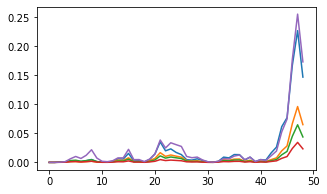

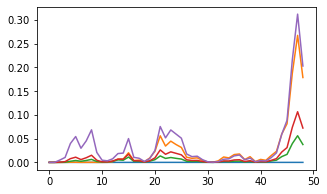

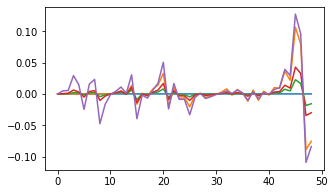

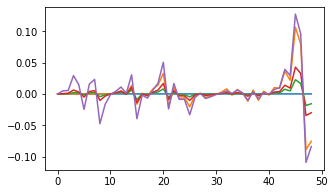

In [9]:
var_changes_L0_w, var_changes_L2_w, var_changes_L4_w, var_changes_L6_w, var_changes_L7_w = [], [], [], [], [] 
var_accumulate_L0_w, var_accumulate_L2_w, var_accumulate_L4_w, var_accumulate_L6_w, var_accumulate_L7_w = [], [], [], [], [] 

var_changes_L0_b, var_changes_L2_b, var_changes_L4_b, var_changes_L6_b, var_changes_L7_b = [], [], [], [], [] 
var_accumulate_L0_b, var_accumulate_L2_b, var_accumulate_L4_b, var_accumulate_L6_b, var_accumulate_L7_b = [], [], [], [], [] 


for global_epoch in range(G_epoch-2):
    for layer_index in num_layers_list:
        globals()['var_accumulate_L{}_w'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][0]))
        globals()['var_changes_L{}_w'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)][0]) - np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][0]))
        
        globals()['var_accumulate_L{}_b'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][1]))
        globals()['var_changes_L{}_b'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)][1]) - np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][1]))
        

print("Variance Accumulate Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Accumulate Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_w'.format(j)])

print("\nVar Accumulate Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_b'.format(j)])

print("\n\nVariance Change Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Changes Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_changes_L{}_w'.format(j)])

print("\nVar Changes Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_changes_L{}_b'.format(j)])



print("\nNow Check the graph\n")

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_w'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_b'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_b'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_b'.format(j)])


Distance Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------
[0.0046230275, 0.04722723, 0.013386074, 0.054140806, 0.023673726, 0.040998623, 0.03977167, 0.015423127, 0.057242256, 0.012602895, 0.025813947, 0.080704264, 0.06668941, 0.04826376, 0.07198388, 0.15193345, 0.035329733, 0.040462766, 0.16669981, 0.08071148, 0.08910888, 0.14884135, 0.028382434, 0.058847085, 0.026813665, 0.062109515, 0.01666459, 0.042260427, 0.03622801, 0.03245676, 0.011992241, 0.12622972, 0.12726219, 0.066394486, 0.037849024, 0.027333746, 0.12683433, 0.09293173, 0.14665219, 0.15321791, 0.058909044, 0.17893396, 0.04859382, 0.15550771, 0.042146698, 0.21752402, 0.09655954, 0.18658619, 0.18345904]
[0.0027774533, 0.03135948, 0.013148366, 0.02192943, 0.01913007, 0.016016398, 0.012388036, 0.0077821133, 0.017504, 0.0060132514, 0.008838745, 0.03372866, 0.055164523, 0.011593903, 0.08093682, 0.10701448, 0.013844718, 0.04291696, 0.060008533, 0.05717265, 0.08831003

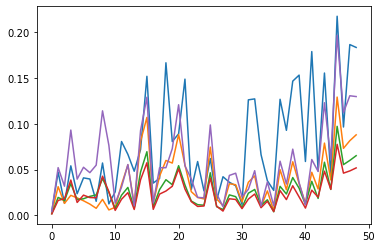

In [10]:
from scipy.spatial import distance

dist_0, dist_2, dist_4, dist_6, dist_7  = [], [], [], [], []

for global_epoch in range(G_epoch-2):
    for layer_index in num_layers_list:
        globals()['dist_{}'.format(layer_index)].append(np.mean(distance.euclidean(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)], globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)])))



print("Distance Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------")
print(dist_0)
print(dist_2)
print(dist_4)
print(dist_6)
print(dist_7, "\n\nCheck the graph\n")

plt.plot(dist_0)
plt.plot(dist_2)
plt.plot(dist_4)
plt.plot(dist_6)
plt.plot(dist_7)

plt.show()

Average Acc and Loss Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------
[[0.8004201650619507, 0.7352941036224365, 0.8088235259056091, 0.7773109078407288, 0.8067227005958557, 0.7815126180648804, 0.7605041861534119, 0.7605041861534119, 0.8298319578170776, 0.7668067216873169, 0.7920168042182922, 0.8235294222831726, 0.7920168042182922, 0.8046218752861023, 0.8046218752861023, 0.7331932783126831, 0.7415966391563416, 0.6701680421829224, 0.7857142686843872, 0.8067227005958557], [0.0903361365199089, 0.09243697673082352, 0.09243697673082352, 0.0714285746216774, 0.08403361588716507, 0.6176470518112183, 0.09873949736356735, 0.13235294818878174, 0.10084033757448196, 0.08403361588716507, 0.1071428582072258, 0.08613445609807968, 0.5630252361297607, 0.09243697673082352, 0.10084033757448196, 0.5378151535987854, 0.1071428582072258, 0.08403361588716507, 0.09873949736356735, 0.5252100825309753], [0.6596638560295105, 0.6134454011917114, 0.6533

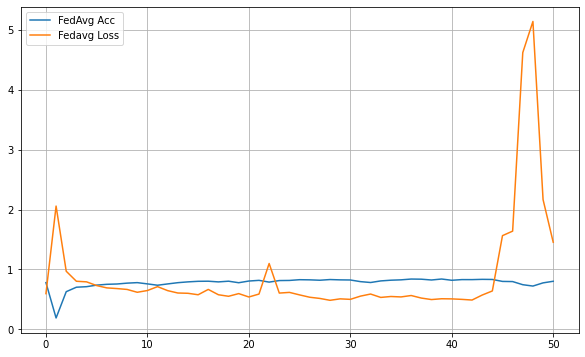

In [11]:
average_acc_list, average_loss_list = [], []


for i in range(len(FedAvg_ACC)):
    average_acc_list.append(np.mean(FedAvg_ACC[i]))
    average_loss_list.append(np.mean(FedAvg_LOSS[i]))
    

print("Average Acc and Loss Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------")
print(FedAvg_ACC)
print(FedAvg_LOSS)
print("\n\n Now Check the graph\n")

plt.figure(figsize=(10,6))
plt.plot(average_acc_list, label='FedAvg Acc')
#print(FedAvg_ACC)
#print(FedAvg_LOSS)
plt.plot(average_loss_list, label='Fedavg Loss')

plt.grid(True)
plt.legend()
plt.show()
